In [1]:
import ml_combat as ml
from ml_combat import data, module_dir

In [2]:
df_train = data.get_training_flattened()
df_test = data.get_testing_flattened()

c:\Users\henri\Dropbox\NTNU\Fall 2023\TDT4173 - Machine Learning\Exercises\Group Exercise\stabekk\ml_combat\data.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return get_training().groupby(level = [0,2], axis = 1).mean()[['y', 'estimated', 'observed']]
c:\Users\henri\Dropbox\NTNU\Fall 2023\TDT4173 - Machine Learning\Exercises\Group Exercise\stabekk\ml_combat\data.py:163: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(level = [0,2], axis = 1).mean()[['estimated']]


In [3]:
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
df_train.head()

,location,ds,y,weather_data_type,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,A,2019-06-02 22:00:00,0.00,observed,7.700,1.22825,1728.950012,0.000000,0.00,1728.950012,...,348.036758,-3.77425,0.0,286.224998,100.000,40386.475586,3.600,-3.575,-0.500,0.0
1,A,2019-06-02 23:00:00,0.00,observed,7.700,1.22350,1689.824982,0.000000,0.00,1689.824982,...,91.980751,-4.35725,0.0,286.899994,100.000,33770.649414,3.350,-3.350,0.275,0.0
2,A,2019-06-03 00:00:00,0.00,observed,7.875,1.21975,1563.225006,0.000000,0.00,1563.225006,...,14.934750,-3.30950,0.0,286.949997,100.000,13595.500000,3.050,-2.950,0.750,0.0
3,A,2019-06-03 01:00:00,0.00,observed,8.425,1.21800,1283.425018,208.649994,0.75,1283.425018,...,28.630250,-0.82250,0.0,286.750000,100.000,2321.850037,2.725,-2.600,0.875,0.0
4,A,2019-06-03 02:00:00,19.36,observed,8.950,1.21800,1003.500000,32468.150269,23.10,1003.500000,...,41.997500,3.05125,0.0,286.449997,99.225,11634.799683,2.550,-2.350,0.925,0.0


In [5]:
keep_columns = ['total_rad_1h:J',
                'fresh_snow_12h:cm',
                'snow_water:kgm2',
                'is_day:idx',
                'is_in_shadow:idx',
                'rain_water:kgm2',
                'sun_azimuth:d',
                'sun_elevation:d',
                't_1000hPa:K',
                'dew_or_rime:idx',
                'air_density_2m:kgm3',
                'absolute_humidity_2m:gm3',
                'y'
]

In [20]:
# Need this to unscale values again
scaler = None

def preprocess(df, has_target_col=False):
  window_len = 20
  batch_size = 32

  temp_df = df.copy()

  temp_df['total_rad_1h:J'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']

  # Only keep the columns in keep_columns that df actually has
  keep_columns_exist = [col for col in keep_columns if col in temp_df.columns]
  temp_df = temp_df[keep_columns_exist]

  
  # Clean out NaNs/NONEs -- May need to remove for more than just total_rad_1h:J
  temp_df = temp_df.dropna(axis=0, how="all", subset="total_rad_1h:J")

  if(has_target_col):
    temp_df = temp_df.dropna(axis=0, how="all", subset="y")

  # Min-max scale all columns so all values in [0, 1]
  scaler = MinMaxScaler()
  temp_np = scaler.fit_transform(temp_df)

  # Convert to time-series of given window-lengths 
  # (Sequence_length is how long each time-window is, sequence_stride is how long the window shifts forward in time for each sequence)
  if(has_target_col):
    num_features = temp_np.shape[1] - 1

    print("NUMBER OF FEATURES", num_features)

    features = temp_np[:, : num_features]
    targets = temp_np[:, num_features]

    temp_df = TimeseriesGenerator(data=features, targets=targets, length=window_len, shuffle=False, batch_size=batch_size)
 
  else:
    num_features = temp_np.shape[1]

    print("NUMBER OF FEATURES", num_features)

    features = temp_np[:, : num_features]
    dummy_targets = np.zeros(features.shape)

    temp_df = TimeseriesGenerator(data=features, targets=dummy_targets, length=window_len, shuffle=False, batch_size=batch_size)
  # Actually returns tensor BatchDataset
  return temp_df

In [ ]:
##################### TRAIN AND OUTPUT FOR DELIVERY #######################


In [8]:
# Test-train split data
train_end = round(len(df_train) * 0.7)

train_train_df = df_train.iloc[:train_end]
train_test_df = df_train.iloc[train_end:]

train_generator = preprocess(train_train_df, has_target_col = True)
test_generator = preprocess(train_test_df, has_target_col=True)

print(len(train_generator))

NUMBER OF FEATURES 12
NUMBER OF FEATURES 12
2090


c:\Python39\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python39\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python39\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python39\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

(array([[[0.1979189 , 0.        , 0.11946902, ..., 0.5       ,
          0.26933328, 0.53153155],
         [0.16027924, 0.        , 0.11504425, ..., 0.5       ,
          0.27377783, 0.54054053],
         [0.10702403, 0.        , 0.1238938 , ..., 0.5       ,
          0.27733355, 0.54054053],
         ...,
         [0.30871503, 0.        , 0.        , ..., 0.5       ,
          0.30222222, 0.42192193],
         [0.40314963, 0.        , 0.        , ..., 0.5       ,
          0.29422238, 0.3963964 ],
         [0.52589553, 0.        , 0.        , ..., 0.5       ,
          0.29155559, 0.38138138]],
 
        [[0.16027924, 0.        , 0.11504425, ..., 0.5       ,
          0.27377783, 0.54054053],
         [0.10702403, 0.        , 0.1238938 , ..., 0.5       ,
          0.27733355, 0.54054053],
         [0.09781674, 0.        , 0.07522124, ..., 0.5       ,
          0.28177778, 0.53753755],
         ...,
         [0.40314963, 0.        , 0.        , ..., 0.5       ,
          0.29422238, 0.

In [10]:
window_len = 20
num_features = 12
epochs = 5

model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(window_len, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(32, return_sequences=False))

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

# Add pruning measures
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=tf.metrics.MeanAbsoluteError())

In [11]:
# Train the model
history = model.fit_generator(train_generator, epochs=epochs, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])

print(model.evaluate(test_generator, verbose=0))

Epoch 1/5


C:\Users\henri\AppData\Local\Temp/ipykernel_18632/3138280237.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=epochs, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])


2090/2090 [==============================] - 55s 24ms/step - loss: 0.0096 - mean_absolute_error: 0.0498 - val_loss: 0.0254 - val_mean_absolute_error: 0.0722
Epoch 2/5
2090/2090 [==============================] - 45s 21ms/step - loss: 0.0071 - mean_absolute_error: 0.0427 - val_loss: 0.0243 - val_mean_absolute_error: 0.0728
Epoch 3/5
2090/2090 [==============================] - 45s 21ms/step - loss: 0.0059 - mean_absolute_error: 0.0385 - val_loss: 0.0228 - val_mean_absolute_error: 0.0705
Epoch 4/5
2090/2090 [==============================] - 46s 22ms/step - loss: 0.0055 - mean_absolute_error: 0.0369 - val_loss: 0.0226 - val_mean_absolute_error: 0.0705
Epoch 5/5
2090/2090 [==============================] - 45s 21ms/step - loss: 0.0053 - mean_absolute_error: 0.0361 - val_loss: 0.0224 - val_mean_absolute_error: 0.0698
[0.02238134853541851, 0.06978625059127808]


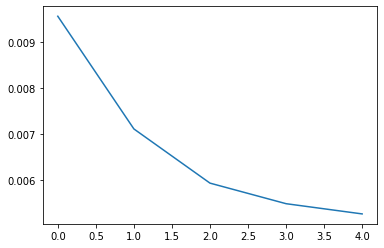

In [13]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])

In [21]:
final_test_generator = preprocess(df_test)
out = model.predict(final_test_generator)

c:\Python39\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python39\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


NUMBER OF FEATURES 12
67/67 [==============================] - 1s 7ms/step


In [25]:
print(out)
print(len(out))
print(len(df_test))
if(len(out) != len(df_test)):
  print("#################################################################")
  print("#################################################################")
  print("########################   PROBLEM          #####################")
  print("################# Likely due to removing Nan-vals  ##############")
  print("#################################################################")
  print("#################################################################")

[[ 0.00415007]
 [ 0.00823158]
 [ 0.00827513]
 ...
 [-0.00240877]
 [ 0.00286565]
 [ 0.00487237]]
2140
2160
#################################################################
#################################################################
########################   PROBLEM          #####################
################# Likely due to removing Nan-vals  ##############
#################################################################
#################################################################
